Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [1]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

%matplotlib inline

In [2]:
# File parameters prefixed pf_

pf_casurl = 'https://covid.ourworldindata.org/data/'
pf_casfil = 'owid-covid-data.csv'       # case file name

pf_datrdc = [                           # columns to read as dates
    3,
]
pf_datcol = 'date'                      # date column
pf_dimcol = 'iso_code'                  # dimension column (location or otherwise)
pf_cascol = [                           # case columns (new, not cumulative)
    'new_cases',
    'new_deaths',
]
pf_namcol = 'location'                  # full dim name
pf_popcol = 'population'                # population column
pf_futext = '365 days'                  # future extension of dataframe
pf_datmrg = '0 days'                    # date margin to ignore at end

We use the daily file from OWID containing new cases and deaths per country per day.

In [3]:
url = pf_casurl + pf_casfil
!wget -N $url

--2021-04-01 09:40:05--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 2606:4700:3038::6815:e98a, 2606:4700:3038::6815:e989, 104.21.233.137, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|2606:4700:3038::6815:e98a|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [         <=>        ]  19.29M  11.3MB/s    in 1.7s    

Last-modified header missing -- time-stamps turned off.
2021-04-01 09:40:07 (11.3 MB/s) - ‘owid-covid-data.csv’ saved [20230161]



We read our dataframe directly from the downloaded file and have a look at the last records for format. Originally, data for Namibia caused missing values because the ISO-2 code is __NA__, so we disable default interpretation of missing values.

In [4]:
df = pd.read_csv(
    pf_casfil,
    keep_default_na = False,
    na_values       = '',
    parse_dates     = pf_datrdc,
    dayfirst        = True,
)

# show the last rows as columns in reverse order
(
    df
    .tail(5)
    .transpose()
    .iloc[:, ::-1]
)

78655  \
iso_code                                               ZWE   
continent                                           Africa   
location                                          Zimbabwe   
date                                   2021-03-31 00:00:00   
total_cases                                        36882.0   
new_cases                                             43.0   
new_cases_smoothed                                    19.0   
total_deaths                                        1523.0   
new_deaths                                             3.0   
new_deaths_smoothed                                    1.0   
total_cases_per_million                           2481.476   
new_cases_per_million                                2.893   
new_cases_smoothed_per_million                       1.278   
total_deaths_per_million                            102.47   
new_deaths_per_million                               0.202   
new_deaths_smoothed_per_million                      0.067   
reproduction_rate                                      NaN   
icu_patients                                           NaN   
icu_patients_per_million                               NaN   
hosp_patients                                          NaN   
hosp_patients_per_million                              NaN   
weekly_icu_admissions                                  NaN   
weekly_icu_admissions_per_million                      NaN   
weekly_hosp_admissions                                 NaN   
weekly_hosp_admissions_per_million                     NaN   
new_tests                                              NaN   
total_tests                                            NaN   
total_tests_per_thousand                               NaN   
new_tests_per_thousand                                 NaN   
new_tests_smoothed                                     NaN   
new_tests_smoothed_per_thousand                        NaN   
positive_rate                                          NaN   
tests_per_case                                         NaN   
tests_units                                            NaN   
total_vaccinations                                     NaN   
people_vaccinated                                      NaN   
people_fully_vaccinated                                NaN   
new_vaccinations                                       NaN   
new_vaccinations_smoothed                              NaN   
total_vaccinations_per_hundred                         NaN   
people_vaccinated_per_hundred                          NaN   
people_fully_vaccinated_per_hundred                    NaN   
new_vaccinations_smoothed_per_million                  NaN   
stringency_index                                       NaN   
population                                      14862927.0   
population_density                                  42.729   
median_age                                            19.6   
aged_65_older                                        2.822   
aged_70_older                                        1.882   
gdp_per_capita                                    1899.775   
extreme_poverty                                       21.4   
cardiovasc_death_rate                              307.846   
diabetes_prevalence                                   1.82   
female_smokers                                         1.6   
male_smokers                                          30.7   
handwashing_facilities                              36.791   
hospital_beds_per_thousand                             1.7   
life_expectancy                                      61.49   
human_development_index                              0.571   

                                                     78654  \
iso_code                                               ZWE   
continent                                           Africa   
location                                          Zimbabwe   
date                                   2021-03-30 00:00:00   
total_cases           

Drop data with missing identifier, determine the last date and provide a last check of our source dataframe.

In [5]:
df = (
    df
    .dropna(
        subset=[
            pf_dimcol,
        ],
    )
)

lastdate = (
    (
        df
        [pf_datcol]
        .max()
    )
    - pd.Timedelta(pf_datmrg)
)
(
    df
    .count()
)

iso_code                                 78656
continent                                74815
location                                 78656
date                                     78656
total_cases                              77102
new_cases                                77100
new_cases_smoothed                       76099
total_deaths                             67703
new_deaths                               67861
new_deaths_smoothed                      76099
total_cases_per_million                  76683
new_cases_per_million                    76681
new_cases_smoothed_per_million           75685
total_deaths_per_million                 67297
new_deaths_per_million                   67455
new_deaths_smoothed_per_million          75685
reproduction_rate                        63300
icu_patients                              8139
icu_patients_per_million                  8139
hosp_patients                             9750
hosp_patients_per_million                 9750
weekly_icu_ad

We pivot to a country by column format.

In [6]:
df_dim = (
    df
    .pivot_table(
        index   = pf_datcol,
        columns = pf_dimcol,
        values  = pf_cascol,
        aggfunc = 'sum',
    )
    .fillna(0)
)

df_dim

new_cases                                                         \
iso_code         AFG    AGO  AIA    ALB   AND     ARE      ARG     ARM  ATG   
date                                                                          
2020-01-01       0.0    0.0  0.0    0.0   0.0     0.0      0.0     0.0  0.0   
2020-01-02       0.0    0.0  0.0    0.0   0.0     0.0      0.0     0.0  0.0   
2020-01-03       0.0    0.0  0.0    0.0   0.0     0.0      0.0     0.0  0.0   
2020-01-04       0.0    0.0  0.0    0.0   0.0     0.0      0.0     0.0  0.0   
2020-01-05       0.0    0.0  0.0    0.0   0.0     0.0      0.0     0.0  0.0   
...              ...    ...  ...    ...   ...     ...      ...     ...  ...   
2021-03-27      36.0   70.0  0.0  425.0  77.0  2304.0  10338.0  1094.0  0.0   
2021-03-28       4.0   32.0  0.0  493.0  41.0  2128.0   7208.0   777.0  6.0   
2021-03-29      28.0   69.0  0.0  285.0  38.0  1874.0  14014.0   424.0  8.0   
2021-03-30      62.0   50.0  0.0  304.0  56.0  2289.0  10154.0   750.0  0.0   
2021-03-31      70.0  129.0  0.0  434.0  66.0  2084.0  16056.0  1148.0  0.0   

                  ... new_deaths                                             \
iso_code     AUS  ...        VAT  VCT   VEN  VNM  VUT  WSM   YEM   ZAF  ZMB   
date              ...                                                         
2020-01-01   0.0  ...        0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0   
2020-01-02   0.0  ...        0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0   
2020-01-03   0.0  ...        0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0   
2020-01-04   0.0  ...        0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0   
2020-01-05   0.0  ...        0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0   
...          ...  ...        ...  ...   ...  ...  ...  ...   ...   ...  ...   
2021-03-27   7.0  ...        0.0  0.0  12.0  0.0  0.0  0.0  12.0  46.0  4.0   
2021-03-28  17.0  ...        0.0  0.0  10.0  0.0  0.0  0.0  19.0  15.0  2.0   
2021-03-29  20.0  ...        0.0  0.0  12.0  0.0  0.0  0.0  12.0  47.0  0.0   
2021-03-30   8.0  ...        0.0  0.0  12.0  0.0  0.0  0.0  19.0  78.0  2.0   
2021-03-31  18.0  ...        0.0  0.0  13.0  0.0  0.0  0.0   6.0  58.0  6.0   

                 
iso_code    ZWE  
date             
2020-01-01  0.0  
2020-01-02  0.0  
2020-01-03  0.0  
2020-01-04  0.0  
2020-01-05  0.0  
...         ...  
2021-03-27  1.0  
2021-03-28  1.0  
2021-03-29  0.0  
2021-03-30  0.0  
2021-03-31  3.0  

[456 rows x 430 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [7]:
new_index = (
    pd.date_range(
        (
            df_dim
            .index
            .min()
        ),
        (
            (
                df_dim
                .index
                .max()
            )
            + pd.Timedelta(pf_futext)
        ),
    )
)
df_dim = (
    df_dim
    .reindex(
        new_index,
    )
)
df_dim

new_cases                                               ...  \
iso_code         AFG  AGO  AIA  ALB  AND  ARE  ARG  ARM  ATG  AUS  ...   
2020-01-01       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-02       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-03       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-04       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-05       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-03-27       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2022-03-28       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2022-03-29       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2022-03-30       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2022-03-31       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

           new_deaths                                               
iso_code          VAT  VCT  VEN  VNM  VUT  WSM  YEM  ZAF  ZMB  ZWE  
2020-01-01        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-04        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2022-03-27        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2022-03-28        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2022-03-29        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2022-03-30        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2022-03-31        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[821 rows x 430 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [8]:
df_dim['daynum'] = (
    (
        (
            df_dim
            .index
        )
        -
        (
            df_dim
            .index
            .min()
        )
    )
    .days
)
(
    df_dim
    ['daynum']
    .describe()
)

count    821.000000
mean     410.000000
std      237.146579
min        0.000000
25%      205.000000
50%      410.000000
75%      615.000000
max      820.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [9]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

In [10]:
import matplotlib as mpl
mpl.rc(
    'figure',
    max_open_warning=0,
)

In [11]:
# Run parameters prefixed pr_

pr_measure  = 'new_cases'               # file column to use as measure
pr_smeasure = 'Week window'             # smoothed measures
pr_rmeasure = 'rcases'                  # remaining measures after iteration
pr_pmeasure = 'Model'                   # projected measures summed
pr_wmeasure = 'Wave '                   # wave name prefix, zero-leading number is added
pr_wavenum  = 2                         # wave numbering width

pr_sdays    = 7                         # number of days for smoothing window
pr_firstwav = 1                         # initial wave number
pr_popcases = 9e9                       # relative minimum from population size (one in n cases)
pr_mincases = 2                         # absolute minimum number of cases to consider

pr_linmax   = -8/20                     # upper bound of linear derivation
pr_linmin   = -8/2                      # lower bound of linear derivation
pr_betamax  = 80/2                      # maximum accepted beta estimate
pr_datamin  = 3                         # minimum number of data points in spline
pr_projmin  = 1                         # minimum cases for projected start and floor
pr_gradmin  = 1e-6                      # minimum gradient difference for knot
pr_wavesig  = 1/10                      # minimum significance for wave

pr_plotshw  = True                      # show plots
pr_plotmin  = '20200101'                # start date of output plots
pr_plotmax  = '20210701'                # stop date of output plots

pr_earth = {                            # pyearth parameters
    'minspan'     : 1,                  # minimal length of spline
    'penalty'     : 0,                  # strictness in pruning
    'endspan'     : 0,                  # measures allowed remaining
    'thresh'      : 1e-9,               # improvement threshold for knot
    'check_every' : 1,                  # measures considered
}
pr_plot = {                             # plot parameters
    'figsize'     : (16, 9),            # figure size
    'grid'        : True,               # show grid
    'kind'        : 'area',             # plot kind
    'stacked'     : False,              # stacking
    'alpha'       : 1/3,                # transparency
}

pr_plnew    = 'Daily new cases for '    # title start for new measure plot
pr_plcum    = 'Cumulative cases for '   # title start for cumulative measure plot

pr_pldate   = (
    ' - '
    + lastdate.strftime('%Y-%m-%d')
)

# Messages

pr_msg_data = '--- no data left'        # not enough data for another fit
pr_msg_wave = '--- no data for wave'    # not enough data for another wave
pr_msg_spur = '--- spurious wave'       # fitted wave probably spurious


Running multiple wave analysis for Netherlands with population 17134873
Minimum number of cases is 2
Wave 01 beta 13.200 mu  86 fit 0.579 peak 2020-03-27 from 2020-02-29 to 2020-06-17 size 6391
Wave 02 beta 13.018 mu  96 fit 0.660 peak 2020-04-06 from 2020-03-08 to 2020-07-16 size 29080
Wave 03 beta  2.667 mu  89 fit 0.588 peak 2020-03-30 from 2020-03-25 to 2020-04-16 size 997
Wave 04 beta  8.549 mu 109 fit 0.654 peak 2020-04-19 from 2020-04-01 to 2020-06-17 size 8137
Wave 05 beta 22.701 mu 160 fit 0.669 peak 2020-06-09 from 2020-04-23 to 2020-10-23 size 8889
Wave 06 beta 14.222 mu 229 fit 0.865 peak 2020-08-17 from 2020-07-16 to 2020-12-02 size 25752
Wave 07 beta  2.348 mu 113 fit 0.483 peak 2020-04-23 from 2020-04-19 to 2020-05-05 size 308
Wave 08 beta 11.918 mu 263 fit 0.888 peak 2020-09-20 from 2020-08-24 to 2020-12-25 size 36957
Wave 09 beta  5.057 mu 268 fit 0.764 peak 2020-09-25 from 2020-09-13 to 2020-11-04 size 13575
Wave 10 beta  5.921 mu 278 fit 0.840 peak 2020-10-05 from 20

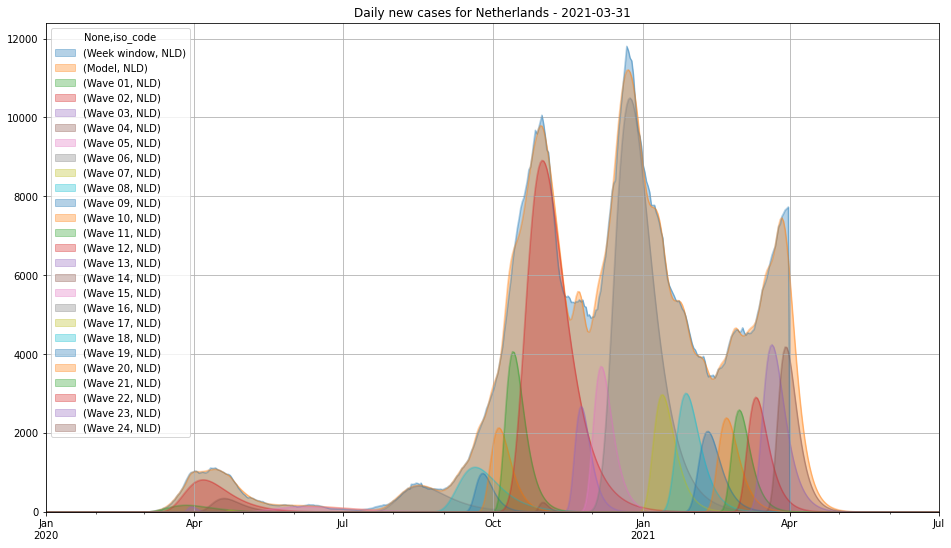

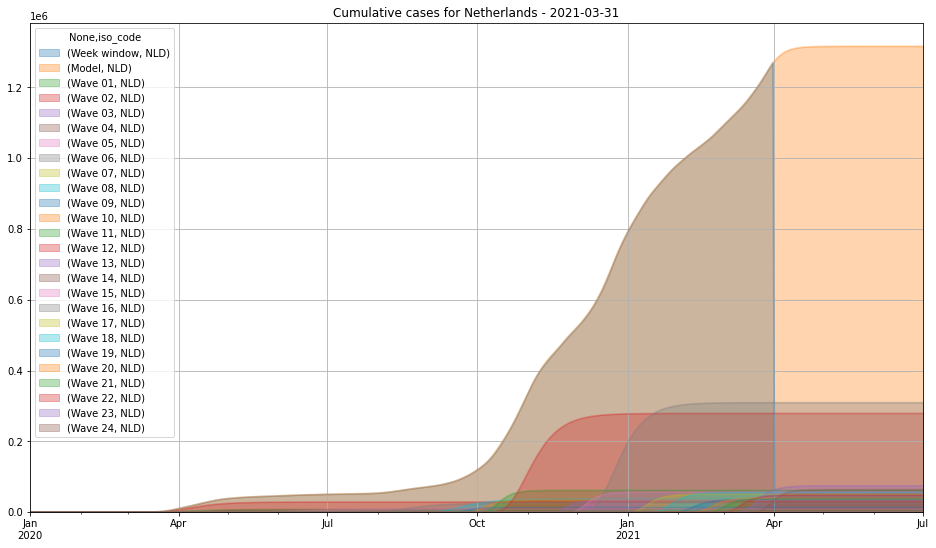

In [12]:
#dimlist = (df[pf_dimcol].unique())
dimlist = [
    'NLD',
#    'ISR',
#    'BEL',
#    'LUX',
#    'DEU',
#    'GBR',
#    'USA',
#    'BRA',
#    'FRA',
#    'ITA',
#    'ESP',
#    'PRT',
#    'OWID_WRL',
]

for pr_dim in dimlist:

    wave = pr_firstwav

    # Initialize predicted measure, create smoothed measure and remaining cases
    df_dim[(pr_pmeasure, pr_dim)] = 0
    df_dim[(pr_smeasure, pr_dim)] = (
        df_dim
        [pr_measure]
        [pr_dim]
        .loc[:lastdate]
        .rolling(pr_sdays)
        .mean()
    )
    df_dim[(pr_rmeasure, pr_dim)] = (
        df_dim
        [pr_smeasure]
        [pr_dim]
    )

    # Always plot smoothed and predicted measures, adding waves when found
    plotlist = [
        (pr_smeasure, pr_dim),
        (pr_pmeasure, pr_dim),
    ]

    # Get full name and population from the original dataset
    dimnam = (
        df
        [df[pf_dimcol] == pr_dim]
        [pf_namcol]
        .iloc[-1]
    )
    dimpop = (
        df
        [df[pf_dimcol] == pr_dim]
        [pf_popcol]
        .iloc[-1]
    )

    # We use a relative minimum number of cases, but at least an absolute
    mincases = max(
        dimpop / pr_popcases,
        pr_mincases,
    )

    print(
        'Running multiple wave analysis for {} with population {:1.0f}'
        .format(
            dimnam,
            dimpop,
        )
    )
    print(
        'Minimum number of cases is {:1.0f}'
        .format(
            mincases,
        )
    )

    while True:
        # Create potential wave
        curwave = (
            pr_wmeasure
            + str(
                wave + 10 ** pr_wavenum
            )
            [-pr_wavenum:]
        )
        df_dim[(curwave, pr_dim)] = 0

        # Create a dataframe for projections
        df_proj = pd.DataFrame(
            {
                'daynum':
                    (
                        df_dim
                        ['daynum']
                    ),
                'measure':
                    (
                        df_dim
                        [pr_rmeasure]
                        [pr_dim]
                    ),
            }
        )

        # Create the Gumbel division and select suitable measures
        df_proj['gumdiv'] = (
            (
                df_proj
                ['measure']
            )
            /
            (
                df_proj
                ['measure']
                .cumsum()
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['gumdiv']
                    > 0
                ) 
                &
                (
                    df_proj
                    ['measure']
                    > mincases
                )
            ]
        )

        # Reduce to log scale and select relevant measures
        df_proj['linear'] = (
            np.log(
                df_proj
                ['gumdiv']
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['linear']
                    < pr_linmax
                ) 
                &
                (
                    df_proj
                    ['linear']
                    > pr_linmin
                )
            ]
        )

        # Do we still have data left?
        if len(df_proj) <= 1:
            print(pr_msg_data)
            break

        # Create input vectors for regression splines and build a model
        eax = (
            df_proj
            ['daynum']
            .values
            .reshape(-1, 1)
        )
        eay = (
            df_proj
            ['linear']
            .values
            .reshape(-1, 1)
        )
        eamodel = Earth(**pr_earth)
        (
            eamodel
            .fit(
                eax,
                eay,
            )
        )

        # Store the results
        df_proj['earth'] = (
            eamodel
            .predict(
                eax,
            )
        )

        # Find the day range
        daymin = (
            df_proj
            ['daynum']
            .min()
        )
        daymax = (
            df_proj
            ['daynum']
            .max()
        )

        # Find the gradient of generated regression splines
        df_proj['gbgrad'] = (
            (
                df_proj
                ['linear']
            )
            -
            (
                df_proj
                ['linear']
                .shift(1)
            )
        )
        df_proj['eagrad'] = (
            (
                df_proj
                ['earth']
            )
            -
            (
                df_proj
                ['earth']
                .shift(1)
            )
        )

        # Knots are found when the gradient changes, including start and end
        df_proj['knot'] = (
            (
                abs(
                    (
                        df_proj
                        ['eagrad']
                    )
                    - 
                    (
                        df_proj
                        ['eagrad']
                        .shift(1)
                    )
                )
                > pr_gradmin
            ) 
            |
            (
                df_proj
                ['daynum']
                == (daymin + 1)
            ) 
            |
            (
                df_proj
                ['daynum']
                == daymax
            )
        )

        # Starting day of each spline
        df_proj['daycount'] = (
            df_proj
            .reset_index()
            .index
        )
        
        # Select the knots and find the actual number of days for each spline
        df_knot = (
            df_proj
            [
                df_proj
                ['knot']
            ]
            [
                [
                    'daynum',
                    'daycount',
                    'eagrad',
                ]
            ]
        )
        
        df_knot['daysdata'] = (
            (
                df_knot
                ['daycount']
                .shift(-1)
            )
            -
            (
                df_knot
                ['daycount']
            )
        )
        df_knot['daystime'] = (
            (
                df_knot
                ['daynum']
                .shift(-1)
            )
            -
            (
                df_knot
                ['daynum']
            )
        )

        # Candidate knots have a negative gradient and a minimum number of days
        df_knot['cand'] = (
            (
                df_knot
                ['eagrad']
                < - (1 / pr_betamax)
            ) 
            &
            (
                df_knot
                ['daysdata']
                >= pr_datamin
            )
        )

        # We want early knots with a low gradient and many days
        df_knot['since'] = (
            (
                df_knot
                ['daynum']
            )
            - daymin
        )
        df_knot['score'] = (
            (
                df_knot
                ['eagrad']
                ** 2
            ) 
            *
            np.sqrt(
                (
                    df_knot
                    ['daysdata']
                )
                /
                np.sqrt(
                    df_knot
                    ['since']
                )
            )
        )
        df_knot['choice'] = (
            (
                df_knot
                ['score']
            )
            ==
            (
                df_knot
                [
                    df_knot
                    ['cand']
                ]
                ['score']
                .max()
            )
        )

        # Did we find another wave?
        choice = (
            df_knot
            [
                df_knot
                ['choice']
            ]
        )
        if len(choice) == 0:
            print(pr_msg_wave)
            break

        # Find the interval of the selected spline
        lower = (
            choice
            ['daynum']
            .values[0]
        )
        upper = (
            choice
            ['daysdata']
            .values[0]
            + lower
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['daynum']
                    >= lower
                ) 
                &
                (
                    df_proj
                    ['daynum']
                    <= upper
                )
            ]
            .copy()
        )

        # Calculate slope and intercept as basis for beta and mu
        fitmod = export.export_python_function(eamodel)
        slope = (
            (
                fitmod([[upper]])[0]
                - fitmod([[lower]])[0]
            ) 
            /
            (
                upper
                - lower
            )
        )
        intercept = (
            fitmod([[lower]])[0]
            - (lower * slope)
        )
        beta = - 1 / slope
        mu = beta * (intercept + np.log(beta))

        # Apply the Gumbel PDF according to beta and mu and find the scale
        df_proj['pgumb'] = gumpdf(
            (
                df_proj
                ['daynum']
            ),
            beta,
            mu,
        )
        df_proj['scale'] = (
            (
                df_proj
                ['measure']
            )
            /
            (
                df_proj
                ['pgumb']
            )
        )
        final = (
            df_proj
            ['scale']
            .mean()
        )
        fincv = (
            df_proj
            ['scale']
            .std()
            / final
        )

        # Did we find a spurious wave?
        if ((1 - fincv) ** 2) < pr_wavesig:
            print(pr_msg_spur)
            break

        # Calculate the current wave and its parameters
        df_dim[(curwave, pr_dim)] = (
            gumpdf(
                (
                    df_dim
                    ['daynum']
                ),
                beta,
                mu,
            )
            * final
        )
        peak = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                )
                == 
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .max()
                )
            ]
            .index
            .min()
        )
        start = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    >= pr_projmin
                ) 
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index
                    < peak
                )
            ]
            .index
            .min()
        )
        floor = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    < pr_projmin
                ) 
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index 
                     > peak
                )
            ]
            .index
            .min()
        )
        print(
            '{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'
            .format(
                curwave,
                beta,
                mu,
                (1 - fincv) ** 2,
                peak.date(),
                start.date(),
                floor.date(),
                final,
            )
        )

        # Move the data from remainder to prediction
        df_dim[(pr_pmeasure, pr_dim)] += (
            df_dim
            [curwave]
            [pr_dim]
        )
        df_dim[(pr_rmeasure, pr_dim)] -= (
            df_dim
            [curwave]
            [pr_dim]
        )
        
        plotlist += [(curwave, pr_dim)]
        wave += 1

    if pr_plotshw:
        (
            df_dim
            [plotlist]
            .loc[pr_plotmin:pr_plotmax]
            .plot(
                **pr_plot,
                title=(
                    pr_plnew
                    + dimnam
                    + pr_pldate
                ),
            )
        )
        (
            df_dim
            [plotlist]
            .loc[pr_plotmin:pr_plotmax]
            .cumsum()
            .plot(
                **pr_plot,
                title=(
                    pr_plcum
                    + dimnam
                    + pr_pldate
                ),
            )
        )

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [13]:
progress = (
    (
        df_dim
        [pr_measure]
        [pr_dim]
        .sum()
    )
    /
    (
        df_dim
        [pr_pmeasure]
        [pr_dim]
        .sum()
    )
)
print(
    'Currently at {:1.2f}% of {:1.0f}'
    .format(
        progress * 100,
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .sum()
        ),
    )
)

Currently at 98.22% of 1316266


The peak date is at the maximum value.

In [14]:
peak = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
        )
        ==
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .max()
        )
    ]
    .index
    .min()
)
print(
    'Peak at {}'
    .format(
        peak.date(),
    )
)

Peak at 2020-12-23


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [15]:
print(
    'Peak by last mu at {}'
    .format(
        (
            df_dim
            .loc[
                (
                    df_dim
                    ['daynum']
                )
                ==
                (
                    mu
                    .astype(int)
                )
            ]
            .index[0]
            .date()
        ),
    )
)

Peak by last mu at 2021-03-29


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [16]:
floor = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            < (dimpop / pr_popcases)
        ) 
        &
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .index
            > peak
        )
    ]
    .index
    .min()
)
print(
    'Floor at {}'
    .format(
        floor.date(),
    )
)

Floor at 2021-07-05


Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [17]:
start = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            > (dimpop / pr_popcases)
        ) 
        &
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .index
            < peak
        )
    ]
    .index
    .min()
)
print(
    'Start at {}'
    .format(
        start.date(),
    )
)

Start at 2020-02-21


We define the maximum delta as the day in the curve with the sharpest rise.

In [18]:
maxrise = (
    (
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
        )
        -
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .shift()
        )
    )
    .max()
)
maxdelta = (
    df_dim
    [
        (
            (
                df_dim
                [pr_pmeasure]
                [pr_dim]
            )
            -
            (
                df_dim
                [pr_pmeasure]
                [pr_dim]
                .shift(1)
            )
        ) 
        == maxrise
    ]
    .index
    .min()
)
print(
    'Largest rise of {:1.0f} on {}'
    .format(
        maxrise,
        maxdelta.date(),
    )
)

Largest rise of 483 on 2020-12-15


This should match the maximum gradient of the daily data.

In [19]:
print(
    'Maximum gradient is {:1.0f}'
    .format(
        (
            np.gradient(
                df_dim
                [pr_pmeasure]
                [pr_dim]
            )
            .max()
        ),
    )
)

Maximum gradient is 479


Back to the original curve, showing the number of infected concurrently.

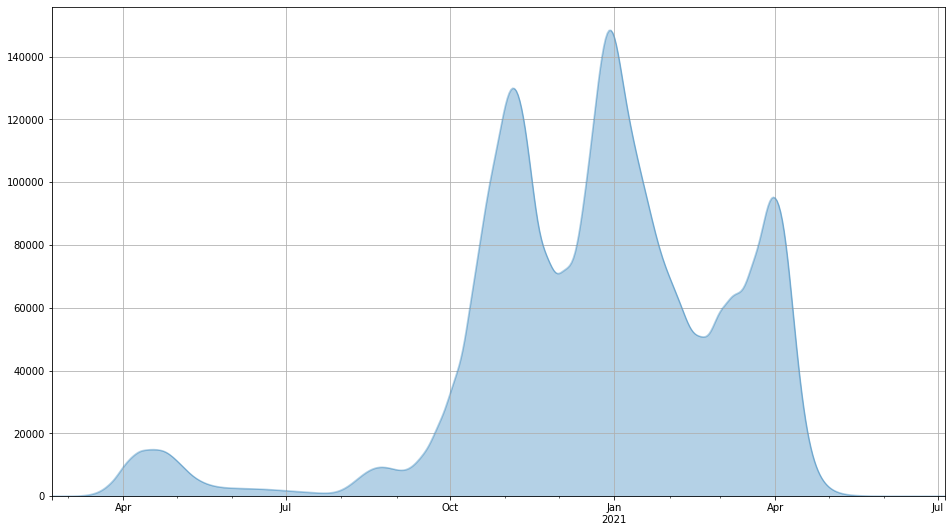

In [20]:
(
    df_dim
    [pr_pmeasure]
    [pr_dim]
    .rolling(14)
    .sum()
    .loc[start:floor]
    .plot(
        figsize=(16, 9),
        grid=True,
        kind='area',
        stacked=False,
        alpha=1/3,
    )
)

The top of this curve gives the maximum number of people that are infected at the same time.

In [21]:
print(
    'Maximum infected is {:1.0f}'
    .format(
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .rolling(14)
            .sum()
            .max()
        ),
    )
)

Maximum infected is 148365


An approximation of the infection rate is the number of infected over the last week divided by the number of infectious in the two weeks before that, at least showing outbreak development.

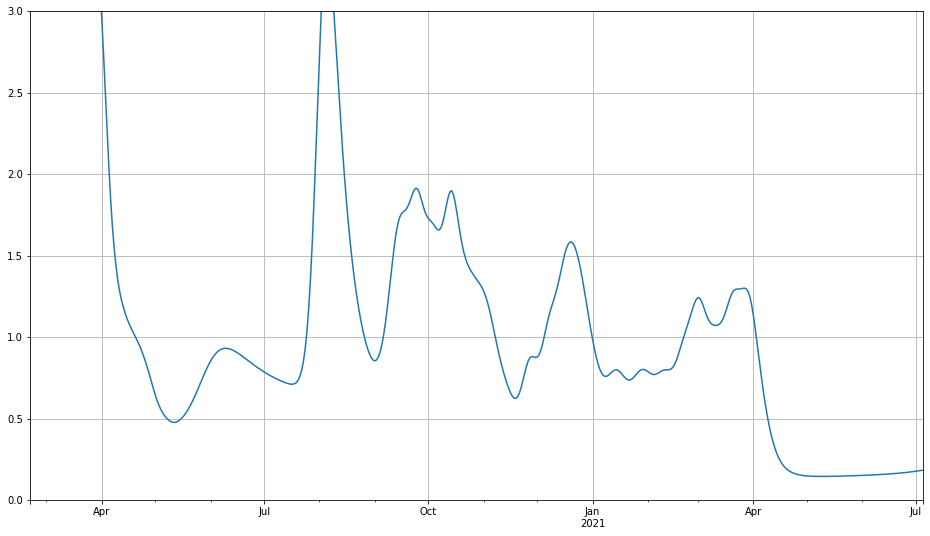

In [22]:
(
    (
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .rolling(7)
            .mean()
        ) 
        /
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .shift(7)
            .rolling(14)
            .mean()
        )
    )
    .loc[start:floor]
    .plot(
        figsize=(16, 9),
        grid=True,
        ylim=(0, 3),
    )
)

If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a second wave, an increase in testing or other factors. This also shows the residuals of our fit.

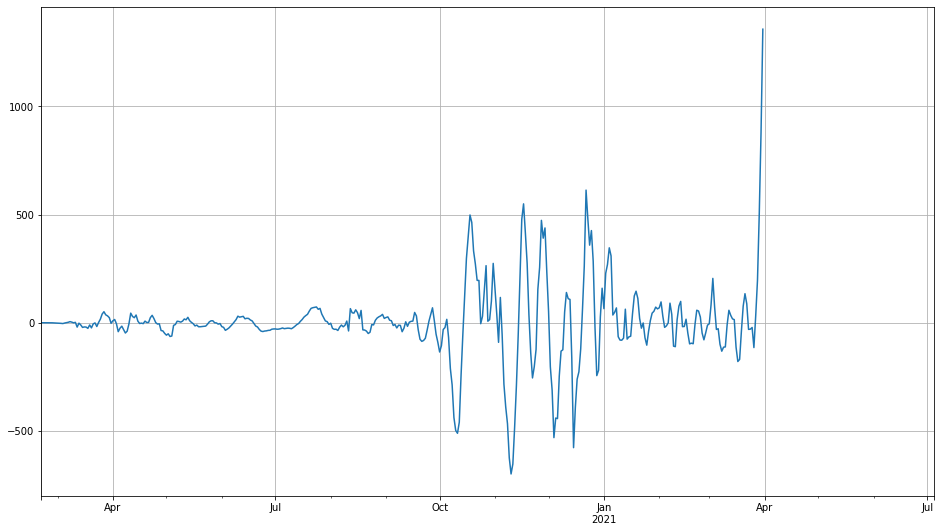

In [23]:
(
    (
        (
            df_dim
            [pr_smeasure]
            [pr_dim]
        )
        -
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
        )
    )
    .rolling(1)
    .mean()
    .loc[start:floor]
    .plot(
        figsize=(16, 9),
        grid=True,
    )
)

Keep exploring! Stay home, wash your hands, keep your distance.